In [107]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, Exponentiation,RationalQuadratic, WhiteKernel
import random

In [108]:
def generate_fake_data(xmin, xmax, n_samples=10, polynomial_degree=2, noise_level=1):
    x = [random.uniform(xmin, xmax) for _ in range(n_samples)]
    # Generate random noise of the same length as x
    noise = np.random.normal(scale=noise_level, size=n_samples)
    # Generate the y values according to a polynomial equation with some added noise
    y = np.polyval([random.uniform(0,10) for _ in range(polynomial_degree + 1)], x) + noise
    # y = np.abs(y) # force y to be positive
    return np.array(x), np.array(y)

In [109]:
x,y = generate_fake_data(0, 10, 5, polynomial_degree=3, noise_level=5)

### Step 1: GP Fit

In [110]:
def GPR(X, Y, kernel= None):
    """
    Fit GP to demand
    run once per product

    :param X: X values with shape (-1, 1)
    :param Y: Y values with shape (-1, 1)
    :param kernel: kernel for the GP
    :return: GPR model
    """

    kernel = kernel
    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gaussian_process.fit(X, Y)
    return gaussian_process

model = GPR(x.reshape(-1,1),y.reshape(-1,1), kernel = 1 * RationalQuadratic(alpha= 10, length_scale=1000) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e2)))
print(model)

GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=10, length_scale=1e+03) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)


/opt/miniconda3/envs/env_gal/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/env_gal/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


### Test Step 1

In [111]:
### Plot model to check
Xplot = np.linspace(-0.1, 10.1, 100)
f_mean, f_var = model.predict(Xplot.reshape(-1,1), return_std=True)

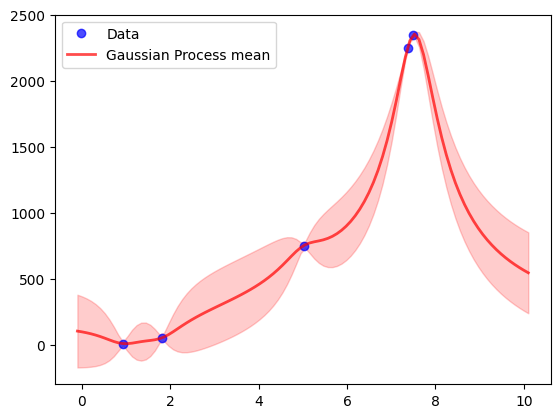

In [112]:
plt.plot(x, y, 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, f_mean, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, f_mean - f_var, f_mean + f_var, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend(); plt.show();

### Step 2 : Sample demand from GP
We use 2 products here to make things simpler

In [296]:
%%capture
### kernel
kernel = 1 * RationalQuadratic(alpha= 1, length_scale=100, length_scale_bounds=(0.01, 1000)) +  WhiteKernel(noise_level=1000, noise_level_bounds=(1e-5, 1e2))
### generate datasets for both products
Ds = [generate_fake_data(0, 1, n_samples=5, polynomial_degree=3, noise_level=10) for _ in range(2)]
### generate GPs for both products
GPs = [GPR(Ds[i][0].reshape(-1,1), Ds[i][1].reshape(-1,1), kernel = kernel) for i in range(2)]

In [297]:
### Plot model to check
Xplot = np.linspace(-0.1, 1.1, 100)
mean0, std0 = GPs[0].predict(Xplot.reshape(-1,1), return_std=True)
mean1, std1 = GPs[1].predict(Xplot.reshape(-1,1), return_std=True)

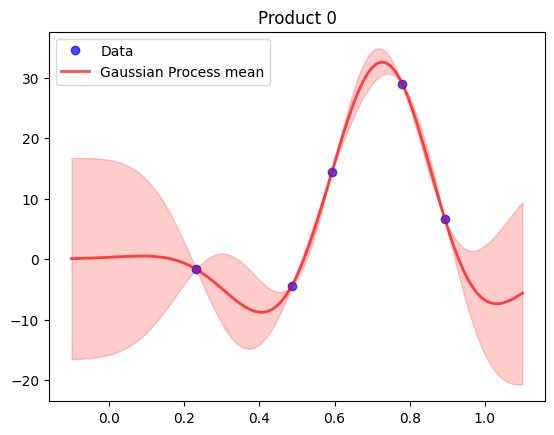

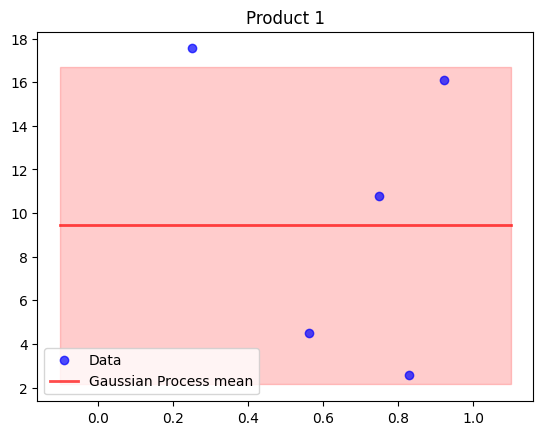

In [298]:
plt.figure()
plt.title('Product 0')
plt.plot(Ds[0][0], Ds[0][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean0, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean0 - std0, mean0 + std0, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

plt.figure()
plt.title('Product 1')
plt.plot(Ds[1][0], Ds[1][1], 'bo', label="""Data""", alpha=0.7)
plt.plot(Xplot, mean1, 'r', linewidth=2, label='Gaussian Process mean', alpha=0.7)
plt.fill_between(Xplot, mean1 - std1, mean1 + std1, alpha=0.2, color='r')
# plt.title("""Ackley's function at $y=0$, GP fit with random samples""", fontsize=14); plt.xlabel('$x$'); plt.ylabel('$f(x)$');
plt.legend()
plt.show()

#### Sample for each price vector

In [299]:
### assume we only offer prices 1, 5, 7 --> get all possible price combinations
import itertools

def get_unique_permutations(lst, length):
    """
    Returns a list of all possible unique permutations of a given length of elements
    in a given list.
    """
    permutations = list(itertools.permutations(lst, length))
    unique_permutations = list(set(permutations))
    result = [list(x) for x in unique_permutations]
    same_val = [result.append([x]*2) for x in lst]
    return result

price_vectors = get_unique_permutations([1, 5, 7, 8], length=2)
print(price_vectors)

[[7, 1], [1, 5], [5, 8], [8, 1], [8, 7], [1, 8], [5, 1], [5, 7], [1, 7], [7, 5], [8, 5], [7, 8], [1, 1], [5, 5], [7, 7], [8, 8]]


##### Check the posterior samples make sense

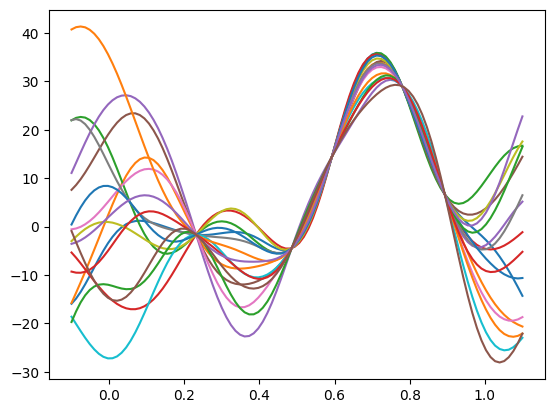

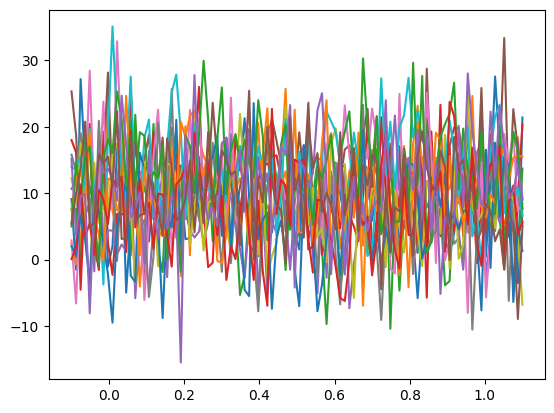

In [300]:
evaluated_y = []
for prod in range(2):
    # Generate samples from posterior distribution. One for each price vector
    y_hat_samples = GPs[prod].sample_y(Xplot.reshape(-1,1), n_samples=len(price_vectors), random_state=None) # no fixed behaviour!
    plt.plot(Xplot, y_hat_samples)
    # for each price vector evaluate demand using the correct GP sample. i.e for 0th element of each price vector, evaluate the GP[0] sample
    # for the 1st element of each price vector, evaluate GP[1] and so on
    evaluated_y.append([np.interp(price_vectors[i][prod], Xplot, y_hat_samples[:,i]) for i in range(len(price_vectors))])
    plt.show()
# combine indexes together to get back to price pairs [price_0, price_1]
evaluations = [list(i) for i in list(zip(*evaluated_y))]

In [301]:
evaluations, price_vectors

([[-14.306990992400216, 6.292425240061355],
  [-12.721006539964574, 6.730932794502049],
  [16.68410441330023, 13.716156766559521],
  [-1.1537533671424738, 9.614169604940322],
  [5.14483045164152, 9.144338106241168],
  [3.6199026282710567, 5.16033116766196],
  [-18.697633724002078, -0.6055749698115989],
  [6.470761901493707, 7.691629901957722],
  [3.4816989689752633, -6.793296069516286],
  [-22.9685586023743, 6.543185017471613],
  [-10.622128623072783, 1.3017712809494046],
  [-22.098552740051336, 15.474272003884897],
  [0.2054529164846448, 13.703159237011745],
  [-5.214517474998139, 5.6589075858263005],
  [22.751351495446972, 8.981986044562388],
  [-22.103896061845173, 4.959696039088781]],
 [[7, 1],
  [1, 5],
  [5, 8],
  [8, 1],
  [8, 7],
  [1, 8],
  [5, 1],
  [5, 7],
  [1, 7],
  [7, 5],
  [8, 5],
  [7, 8],
  [1, 1],
  [5, 5],
  [7, 7],
  [8, 8]])

### Step 3: Solve Linear Program
https://realpython.com/linear-programming-python/

In [302]:
from scipy.optimize import linprog

In [303]:
# define some max quantity of each product
max_inventory = [100000, 100000] # per product (unconstrained)
a = [[1,1] for _ in range(len(price_vectors))] # every time a sale happens we lose 1 product

# first get the coefficients for the linear program
result_for_lp = []
subject_to = []
for k in range(len(price_vectors)): # price vectors
    sub_k_result = []
    sub_subject_to = []
    for i in range(2): # products
        sub_k_result.append(price_vectors[k][i] * evaluations[k][i])
        sub_subject_to.append(a[k][i] * evaluations[k][i])
    subject_to.append(np.sum(sub_subject_to))
    result_for_lp.append(np.sum(sub_k_result))

subject_coeffs = [subject_to]*2 # one is needed per product as cj is different per product (potentially)

# xk inequality (sum of x <= 1)
xk_ineq = list(np.full(len(price_vectors),1))

# combine to make LHS inequalities
subject_coeffs.append(xk_ineq)

lhs_ineq = subject_coeffs # rename to be more clear
# Define RHS of the inequalities
max_inventory.append(1)

rhs_ineq = max_inventory

assert len(rhs_ineq) == len(lhs_ineq)
# xk >= 0 definition
bnd = [(0, 1) for _ in range(len(price_vectors))]

# objective 
result_for_lp = [x*-1 for x in result_for_lp] # maximise!!!

# print(lhs_ineq, "\n")
# print(rhs_ineq)
# print(bnd)
# print(result_for_lp)

opt = linprog(c=result_for_lp, A_ub=lhs_ineq, b_ub=rhs_ineq, bounds=bnd, method="revised simplex")

In [304]:
opt

     con: array([], dtype=float64)
     fun: -222.1333627800655
 message: 'Optimization terminated successfully.'
     nit: 1
   slack: array([99968.26666246, 99968.26666246,     0.        ])
  status: 0
 success: True
       x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

### Random choice from x

In [305]:
choose_price_index = np.argwhere(opt['x'] == np.random.choice(opt['x'], p=opt['x']))[0][0]

In [306]:
price_vectors[choose_price_index]

[7, 7]

### Different LP method

In [307]:
from pulp import GLPK, LpProblem, LpMaximize, LpVariable, lpSum, LpStatus

In [308]:
max_inventory = [100000, 100000] # per product (unconstrained)
a = [[1,1] for _ in range(len(price_vectors))] # every time a sale happens we lose 1 product

# first get the coefficients for the linear program
result_for_lp = []
subject_to = []
for k in range(len(price_vectors)): # price vectors
    sub_k_result = []
    sub_subject_to = []
    for i in range(2): # products
        sub_k_result.append(price_vectors[k][i] * evaluations[k][i])
        sub_subject_to.append(a[k][i] * evaluations[k][i])
    subject_to.append(sub_subject_to)
    result_for_lp.append(np.sum(sub_k_result))

# result_for_lp_norm = (result_for_lp-np.min(result_for_lp))/(np.max(result_for_lp)-np.min(result_for_lp))
# Define the model
model = LpProblem(name="resource-allocation", sense=LpMaximize)

# Define the decision variables
x = {i: LpVariable(name=f"x{i}", lowBound=0, upBound=1) for i in range(0, len(price_vectors))}


# # Add constraints
model += (lpSum(x.values()) <= 1, "xk_constraint")
model += (lpSum([[x[0] for x in subject_to][i]*x[i] for i in range(len(x))]) <= max_inventory[0], "product_0")
model += (lpSum([[x[1] for x in subject_to][i]*x[i] for i in range(len(x))]) <= max_inventory[1], "product_1")

# model += (lpSum([subject_to[i]*x[i] for i in range(len(x))]) <= max_inventory[1], "product_1")

# # Set the objective
model += lpSum([result_for_lp[i]*x[i] for i in range(len(x))])


# # Solve the optimization problem
status = model.solve()

# Get the results
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

for var in x.values():
    print(f"{var.name}: {var.value()}")

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/miniconda3/envs/env_gal/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/pn/7l34wdyd4qnds1fjcqvqqkx40000gn/T/73f4a92aa1274d5ea9875d766ea615cb-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/pn/7l34wdyd4qnds1fjcqvqqkx40000gn/T/73f4a92aa1274d5ea9875d766ea615cb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 73 RHS
At line 77 BOUNDS
At line 94 ENDATA
Problem MODEL has 3 rows, 16 columns and 48 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 0 (-3) rows, 0 (-16) columns and 0 (-48) elements
Empty problem - 0 rows, 0 columns and 0 elements
Optimal - objective value 222.13336
After Postsolve, objective 222.13336, infeasibilities - dual 466.86492 (8), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 222.13336 Dual 

In [309]:
for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

xk_constraint: 2.3030466422824247e-12
product_0: -99977.24864850451
product_1: -99991.01801395541


In [310]:
x_vals_index = np.argmax([x.value() for x in x.values()])

In [311]:
price_vectors[x_vals_index]

[7, 7]

In [292]:
result_for_lp_norm

array([0.51128658, 0.09457604, 0.25936439, 0.92026394, 0.99025   ,
       0.04784833, 0.17182386, 0.29683782, 0.12922602, 0.61034403,
       1.        , 0.55485663, 0.        , 0.29050349, 0.54079014,
       0.9615226 ])